<a href="https://colab.research.google.com/github/pallavibekal/CodeRepository/blob/main/Face_Mask_Detection_CNN_%2B_Pre_trained_Model_VGG16_Pallavi_M4_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Objectives

## Dataset

The data for this mini-project is collected from various sources including the masked images from internet and general frontal face images considered as without mask. This dataset consists of 5029 train images and 1059 test images with 3 classes `with_mask`, `without_mask` and `partial_mask`

Many people are not correctly wearing their masks due to bad practices, bad behaviors or vulnerability of individuals (e.g., children, old people). For these reasons, several mask wearing campaigns intend to sensitize people about this problem and good practices. In this sense, this work proposes three types of masked face detection dataset; namely, the Correctly Masked Face, the Incorrectly Masked Face and their combination for the global masked face detection. This dataset serves the objective of classifying faces that are: 
  
- Without Mask/ With Mask/ Partial Mask
  
Note that this dataset contains some annotated (artificially generated) masks to augment the 'masked' data category.

## Problem Statement

To build and implement a Convolutional Neural Network model to classify between masked/unmasked/partially masked faces.

In [ ]:
#@title Download the data
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/MP2_FaceMask_Dataset.zip
!unzip -qq MP2_FaceMask_Dataset.zip
print("Data Downloaded Successfuly!!")

Data Downloaded Successfuly!!


### Import Required packages

In [ ]:
import numpy as np
import PIL
from matplotlib import pyplot as plt
import glob, os
from tensorflow import keras
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense,Dropout
from keras.models import Model, load_model
from keras.callbacks import TensorBoard, ModelCheckpoint

## Data Loading and preprocessing

### Analyze the shape of images and distribution of classes

In [ ]:
# load and show an image with Pillow
from PIL import Image
# load the image
image = Image.open('/content/MP2_FaceMask_Dataset/train/with_mask/-110695084-mask2.jpg')
# summarize some details about the image
print(image.format)
print(image.mode)
print(image.size)
# show the image
image.show()

JPEG
RGB
(976, 549)


### Load the images using ImageDataGenerator

There are two main steps involved in creating the generator.
1. Instantiate ImageDataGenerator with required arguments to create an object
2. Use the `flow_from_directory` command depending on how your data is stored on disk. This is the command that will allow you to generate and get access to batches of data on the fly.

Hint: [link](https://keras.io/api/preprocessing/image/)

In [ ]:
TRAINING_DIR = "/content/MP2_FaceMask_Dataset/train/"
VALIDATION_DIR = "/content/MP2_FaceMask_Dataset/test/"

In [ ]:
def extract_data(dir,batch,img_height,image_width):

  data = keras.preprocessing.image_dataset_from_directory(
      dir,
      labels="inferred",
      label_mode="int",
      class_names=None,
      color_mode="rgb",
      batch_size=batch,
      image_size=(img_height, image_width),
      shuffle=False,
      seed=11,
      validation_split=None,
      subset=None,
      interpolation="bilinear",
      follow_links=False,
      crop_to_aspect_ratio=False
  )
  return data

In [ ]:
train_ds = extract_data(TRAINING_DIR,50,256,256)

Found 5031 files belonging to 3 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)


['partial_mask', 'with_mask', 'without_mask']


In [ ]:
test_ds = extract_data(VALIDATION_DIR,10,256,256)

Found 1260 files belonging to 3 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)


['partial_mask', 'with_mask', 'without_mask']


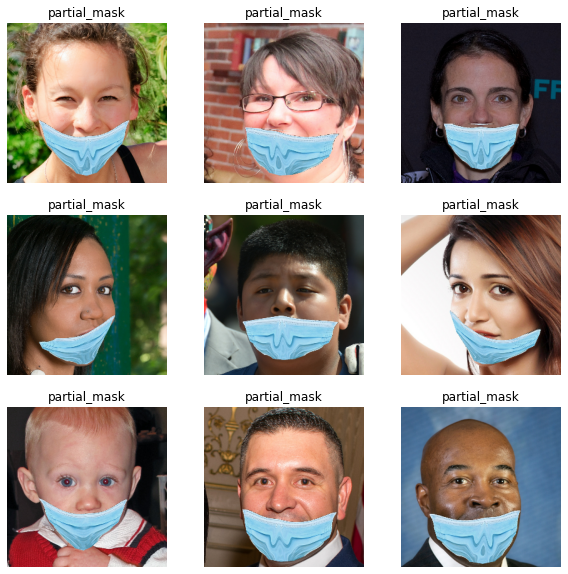

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(100, 256, 256, 3)
(100,)


In [ ]:
train_ds.file_paths

In [ ]:
len(train_ds.file_paths)

5031

In [ ]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy().shape)

Image shape:  (50, 256, 256, 3)
Label:  (50,)


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds


In [ ]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [ ]:
import pathlib

data_dir_train_pm = pathlib.Path('/content/MP2_FaceMask_Dataset/train/partial_mask')
data_dir_train_wm = pathlib.Path('/content/MP2_FaceMask_Dataset/train/with_mask')
data_dir_train_wom = pathlib.Path('/content/MP2_FaceMask_Dataset/train/without_mask')
data_dir_test_pm = pathlib.Path('/content/MP2_FaceMask_Dataset/test/partial_mask')
data_dir_test_wm = pathlib.Path('/content/MP2_FaceMask_Dataset/test/with_mask')
data_dir_test_wom = pathlib.Path('/content/MP2_FaceMask_Dataset/test/without_mask')




In [ ]:
print('Train data - partial mask - ',len(list(data_dir_train_pm.glob('*.jpg'))))
print('Train data - with mask - ',len(list(data_dir_train_wm.glob('*.jpg'))))
print('Train data - without mask - ',len(list(data_dir_train_wom.glob('*.jpg'))))
print('Test data - partial mask - ',len(list(data_dir_test_pm.glob('*.jpg'))))
print('Test data - with mask - ',len(list(data_dir_test_wm.glob('*.jpg'))))
print('Test data - without mask - ',len(list(data_dir_test_wom.glob('*.jpg'))))


Train data - partial mask -  1294
Train data - with mask -  1523
Train data - without mask -  2127
Test data - partial mask -  323
Test data - with mask -  384
Test data - without mask -  527


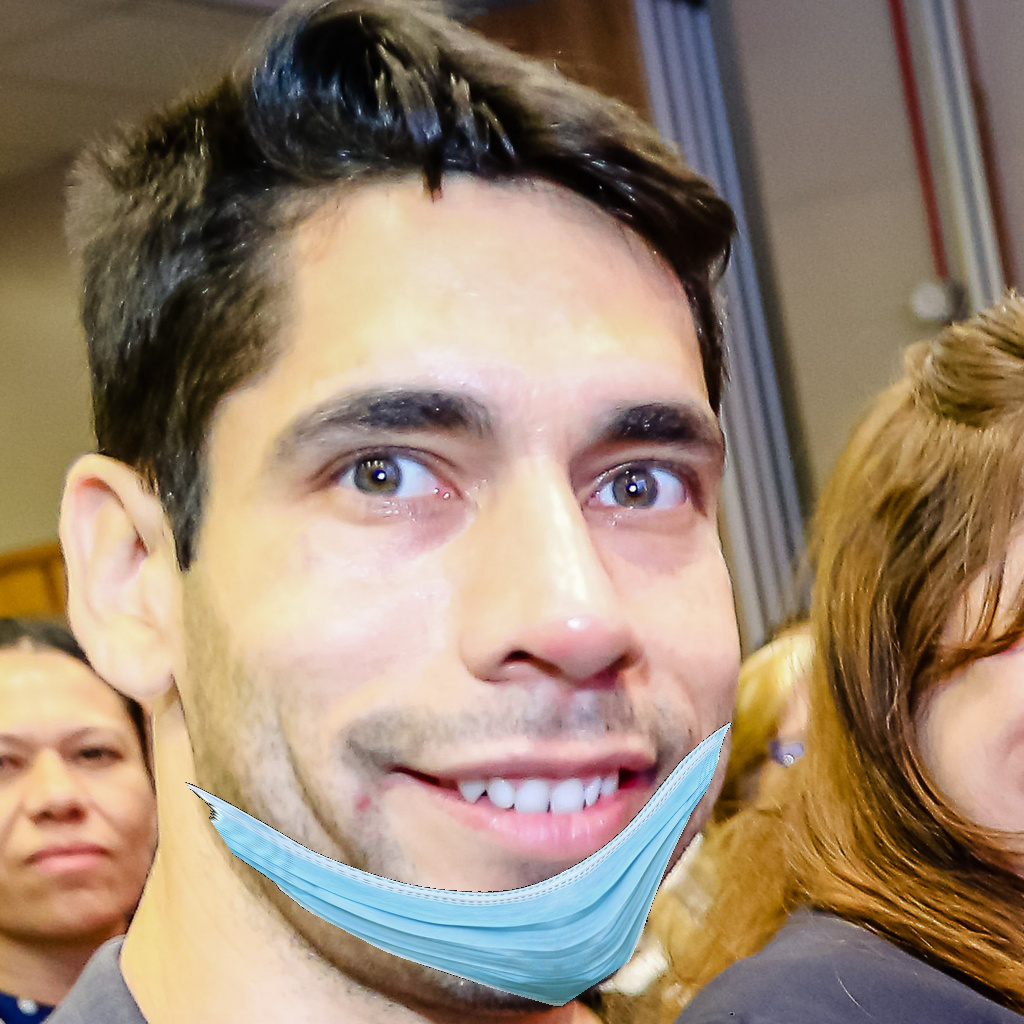

In [ ]:
partial = list(data_dir_train_pm.glob('*'))
PIL.Image.open(str(partial[0]))


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  print(images[0],labels[0])
  #for i in range(9):
  #  ax = plt.subplot(3, 3, i + 1)
  #  plt.imshow(images[i].numpy().astype("uint8"))
  #  plt.title(class_names[labels[i]])
  #  plt.axis("off")


tf.Tensor(
[[[ 93.   120.25  96.  ]
  [ 63.    95.    59.5 ]
  [ 46.    80.5   36.  ]
  ...
  [ 79.75 157.75  16.25]
  [ 78.25 158.75  15.25]
  [ 83.75 161.75  18.25]]

 [[ 72.5  103.    70.25]
  [ 55.25  88.75  48.25]
  [ 44.25  79.5   33.25]
  ...
  [ 61.75 150.75   0.75]
  [ 57.5  148.25   0.  ]
  [ 65.75 152.5    1.5 ]]

 [[ 57.75  90.5   47.5 ]
  [ 54.75  87.25  42.5 ]
  [ 37.25  69.75  22.25]
  ...
  [ 59.75 151.25   1.25]
  [ 56.5  151.     0.25]
  [ 66.25 153.25   4.75]]

 ...

 [[ 18.5   24.25   4.  ]
  [ 25.25  26.75   5.5 ]
  [ 30.75  29.25   5.  ]
  ...
  [192.   138.   112.  ]
  [190.25 136.25 110.25]
  [190.5  135.5  110.  ]]

 [[ 19.75  23.75   5.5 ]
  [ 25.    25.5    5.  ]
  [ 30.75  28.     6.25]
  ...
  [193.   139.   113.  ]
  [195.   140.   114.5 ]
  [191.25 133.25 109.  ]]

 [[ 13.25  18.75   3.25]
  [ 19.75  21.75   4.25]
  [ 26.25  24.5    4.5 ]
  ...
  [194.   140.   114.  ]
  [192.   136.   111.  ]
  [189.25 128.75 105.  ]]], shape=(256, 256, 3), dtype=float32

<Figure size 720x720 with 0 Axes>

In [ ]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

In [ ]:
print(data_dir)

/root/.keras/datasets/flower_photos


In [ ]:
print(tf.data.experimental.cardinality(train_ds).numpy())


51


In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2)

val_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2)

#test_datagen = ImageDataGenerator(rescale = 1./255)  #Image normalization.

training_set = train_datagen.flow_from_directory(TRAINING_DIR,
                                                 target_size = (128, 128),
                                                 interpolation="nearest",
                                                 class_mode='categorical',
                                                 classes=['partial_mask', 'with_mask', 'without_mask'],
                                                 seed=11,
                                                 shuffle=False,
                                                 batch_size = 51)

validation_set = val_datagen.flow_from_directory(VALIDATION_DIR,
                                                 target_size=(128, 128),
                                                 interpolation="nearest",
                                                 class_mode='categorical',
                                                 classes=['partial_mask', 'with_mask', 'without_mask'],
                                                 seed=11,
                                                 shuffle=False,
                                                 batch_size = 13)

#test_set = test_datagen.flow_from_directory(Test_path,
#                                            target_size = (128, 128),
#                                            interpolation="nearest",
#                                            class_mode='binary',
#                                            classes=["WithoutMask","WithMask"])

#interpolation="nearest",
#classes=["without_mask","with_mask"]

Found 5029 images belonging to 3 classes.
Found 1259 images belonging to 3 classes.


In [ ]:
xbatch, ybatch = training_set.next()

In [ ]:
xbatch.shape

(51, 128, 128, 3)

In [ ]:
ybatch.shape

(51, 3)

In [ ]:
len(training_set)

99

## Build the CNN model using Keras (4 points)



**Convolutional Neural Network:** A neural network in which at least one layer is a convolutional layer. A typical convolutional neural network consists of some combination of the following layers:

* convolutional layers
* pooling layers
* dense layers


**Conv2D**  

Passing an image with input shape of 3-D and to calculate the output: 

 $O = \frac{n - f + 2p}{s} + 1$

**MaxPool** 

The resulting output, when using the "valid" padding option, has a spatial shape (number of rows or columns) of: 

O = `math.floor`$(\frac{input shape - pool size)}{ strides}) + 1$ (when input shape >= pool size)

The resulting output shape when using the "same" padding option is: 

O = `math.floor`$(\frac{input shape - 1}{strides}) + 1$

by default, stride = None, so stride is same as pool size

Task-flow
* Initialize the network of convolution, maxpooling and dense layers
* Define the optimizer and loss functions
* Fit the model and evaluate the model

In [ ]:
normalization_layer = keras.layers.Rescaling(1./255)


In [ ]:
# Create model
#model = Sequential([
#                    Conv2D(64, 7, activation="relu", padding="same", input_shape=[976, 549, 3]),
#                    MaxPooling2D(2),
#                    Conv2D(128, 3, activation="relu", padding="same"),
#                    Conv2D(128, 3, activation="relu", padding="same"),
#                    MaxPooling2D(2),
#                    Conv2D(256, 3, activation="relu", padding="same"),
#                    Conv2D(256, 3, activation="relu", padding="same"),
#                    MaxPooling2D(2),
#                    Flatten(),
#                    Dense(128, activation="relu"),
#                    Dropout(0.5),
#                    Dense(64, activation="relu"),
#                    Dropout(0.5),
#                    Dense(10, activation="softmax")
#                    ])

In [ ]:
model = keras.Sequential([
  keras.layers.Rescaling(1./255),
  keras.layers.Conv2D(64, 16, activation='relu',padding="same", input_shape=[128, 128, 3]),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(128, 7, activation='relu',padding="same"),
  keras.layers.Conv2D(128, 7, activation='relu',padding="same"),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(256, 3, activation='relu',padding="same"),
  keras.layers.MaxPooling2D(),
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(3, activation = 'softmax')
])


In [ ]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


In [ ]:
history = model.fit(training_set, validation_data=validation_set ,epochs = 5, steps_per_epoch= 99// 51) #validation_data=test_ds)

Epoch 1/5
1/1 [==============================] - 19s 19s/step - loss: 1.0983 - accuracy: 1.0000 - val_loss: 1.1258 - val_accuracy: 0.4241
Epoch 2/5
1/1 [==============================] - 14s 14s/step - loss: 0.5599 - accuracy: 1.0000 - val_loss: 11.9626 - val_accuracy: 0.4241
Epoch 3/5
1/1 [==============================] - 14s 14s/step - loss: 2.8517e-07 - accuracy: 1.0000 - val_loss: 58.1755 - val_accuracy: 0.4241
Epoch 4/5
1/1 [==============================] - 15s 15s/step - loss: 100.4511 - accuracy: 0.0000e+00 - val_loss: 12.2339 - val_accuracy: 0.4241
Epoch 5/5
1/1 [==============================] - 15s 15s/step - loss: 23.0244 - accuracy: 0.0000e+00 - val_loss: 1.4192 - val_accuracy: 0.4241


## Transfer learning 

Transfer learning consists of taking features learned on one problem, and leveraging them on a new, similar problem.

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

For eg. Using VGG16, we remove the last layer which takes a probability for each of the 1000 classes in the ImageNet and replaces it with a layer that takes 3 probabilities in our case.

### Use the pre-trained models ([VGG16](https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/VGG16) or [ResNet50](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50))

* Load the pre-trained model
* Fit and evaluate the data



Task-flow
* Initialize the network with the weights of Imagenet
* Fine tune the network by modifying fully connected layers.
* Re-train the model with our problem data

In [ ]:
from keras.applications.vgg16 import VGG16

In [ ]:
model = VGG16(
    include_top=True, weights='imagenet', input_tensor=None,
    input_shape=None, pooling=None, classes=3,
    classifier_activation='softmax'
)

In [ ]:
model_vgg = Sequential()
model_vgg.add(VGG16(weights='imagenet',include_top=False,input_shape=(224,224,3)))
model_vgg.add(Flatten())
model_vgg.add(Dense(512,activation="relu",kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.02)))
model_vgg.add(BatchNormalization())
model_vgg.add(Dropout(0.5))
model_vgg.add(Dense(96,activation="relu",kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.02)))
model_vgg.add(BatchNormalization())
model_vgg.add(Dropout(0.5))
model_vgg.add(Dense(training_set.num_classes,activation='softmax'))
model_vgg.summary()



In [ ]:
for idx in range(len(model_vgg.layers)-1): #Leave the second to last layer trainable
  model.layers[idx].trainable = False
model_vgg.layers[len(model_vgg.layers)-1].trainable = True 

In [ ]:
optimizer_adam = keras.optimizers.Adam(learning_rate=0.00001)
model_vgg.compile(optimizer=optimizer_adam, loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
from sklearn.utils import compute_class_weight

In [ ]:
class_weight = compute_class_weight(class_weight='balanced',
                                        classes=np.unique(train_df['tag']),
                                        y=train_df['tag'])


In [ ]:
class_weight

array([1.30242143, 1.03776683, 0.78827565])

In [ ]:
callbacks = [ keras.callbacks.ModelCheckpoint("best_model_vgg1.h5", save_best_only=True, monitor="val_loss")]

In [ ]:
history3 = model_vgg.fit(training_set,epochs=10,
                              validation_data=validation_set, class_weight={0:1.3,1:1,2:0.7},callbacks=callbacks)

Epoch 1/10
99/99 [==============================] - 113s 1s/step - loss: 0.3823 - acc: 0.9994 - val_loss: 0.3965 - val_acc: 0.9952
Epoch 2/10
99/99 [==============================] - 113s 1s/step - loss: 0.3713 - acc: 0.9982 - val_loss: 0.3752 - val_acc: 0.9968
Epoch 3/10
99/99 [==============================] - 113s 1s/step - loss: 0.3576 - acc: 0.9986 - val_loss: 0.3614 - val_acc: 0.9968
Epoch 4/10
99/99 [==============================] - 113s 1s/step - loss: 0.3458 - acc: 0.9992 - val_loss: 0.3780 - val_acc: 0.9921
Epoch 5/10
99/99 [==============================] - 112s 1s/step - loss: 0.3350 - acc: 0.9984 - val_loss: 0.3364 - val_acc: 0.9968
Epoch 6/10
99/99 [==============================] - 112s 1s/step - loss: 0.3229 - acc: 0.9984 - val_loss: 0.3182 - val_acc: 0.9984
Epoch 7/10
99/99 [==============================] - 111s 1s/step - loss: 0.3101 - acc: 0.9990 - val_loss: 0.3195 - val_acc: 0.9944
Epoch 8/10
99/99 [==============================] - 113s 1s/step - loss: 0.2977 - a

In [ ]:
df = pd.DataFrame()
df['img_path'] = glob.glob("FaceMask_Kaggle_test/*")
df['order'] = [int(i.split("/")[1][:-4]) for i in df['img_path']]
df.sort_values('order',inplace=True)
df.reset_index(inplace=True,drop=True)
df

In [ ]:
kaggle_features = []
for i in df.img_path:

#  im = np.array(PIL.Image.open(i).convert('L').resize((224,224)))
  im = np.array(PIL.Image.open(i)  .resize((224,224)))
  if im.shape != (224,224,3):
    print(i, im.shape)
  kaggle_features.append(im)
  
kaggle_features = np.array(kaggle_features)

In [ ]:
# Loading the saved model
model = keras.models.load_model('/content/best_model_vgg1.h5')

In [ ]:
model = keras.models.load_model('/content/best_model.h5')

In [ ]:
pred = model.predict(kaggle_features)

In [ ]:
act_pred = np.argmax(pred,axis=1)
set(act_pred)

{0, 1, 2}

In [ ]:
kaggle = pd.DataFrame()
kaggle['label'] = act_pred
kaggle['img_path'] = df['img_path']
kaggle['label'].replace(0,'partial_mask',inplace=True)
kaggle['label'].replace(1,'with_mask',inplace=True)
kaggle['label'].replace(2,'without_mask',inplace=True)

In [ ]:
kaggle.to_csv("kaggle_submission_w13.csv",index=False)

### Capture the live image using the below code cell and predict

In [ ]:
#@title Capture the photo
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  display(Image(filename))
except Exception as err:
  print(str(err))

After executing above cell and capturing the photo, load the captured photo and predict with model.

**Note:** 
* Convert the image to numpy array and resize to the shape which model accept. 
* Extend the dimension (to 4-D shape) of an image, as the model is trained on a batch of inputs.

In [ ]:
features = PIL.Image.open("photo.jpg")
plt.imshow(features);
# YOUR CODE HERE to predict the image

In [ ]:
group10net = keras.models.load_model('/content/drive/MyDrive/APCDS/fmnistnet+cnn1+denser_sgd_best_model.h5')

In [ ]:
features = PIL.Image.open("photo.jpg")
g10doc = features.resize((150,150))
vgg16doc = features.resize((224,224))
plt.imshow(g10doc);
plt.imshow(vgg16doc);
# YOUR CODE HERE to predict the image
image1=np.array(g10doc)/255
image2=np.array(vgg16doc)/255
doc1 = np.expand_dims(image1, axis=0)
doc2 = np.expand_dims(image2, axis=0)
#print(type(doc), doc.shape)

group10net_predictions = group10net.predict(doc1)
vgg16_predictions = vgg16.predict(doc2)

#print(type(predictions), predictions.shape)


grp10net_pred = np.argmax(group10net_predictions, axis=1)
vgg16_pred = np.argmax(vgg16_predictions, axis=1)

print('Group 10 Net Predicted Class:', np.array(class_names)[grp10net_pred])
print('Transfer Learning Predicted Class:', np.array(class_names)[vgg16_pred])